## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
%matplotlib inline
import glob

In [2]:
#Options and Settings
warnings.simplefilter('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
colors = sns.color_palette("Set3", 10)

In [3]:
#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

## Importing Datasets

Data Description
**client_data.csv**

- id = client company identifier
- activity_new = category of the company’s activity
- channel_sales = code of the sales channel
- cons_12m = electricity consumption of the past 12 months
- cons_gas_12m = gas consumption of the past 12 months
- cons_last_month = electricity consumption of the last month
- date_activ = date of activation of the contract
- date_end = registered date of the end of the contract
- date_modif_prod = date of the last modification of the product
- date_renewal = date of the next contract renewal
- forecast_cons_12m = forecasted electricity consumption for next 12 months
- forecast_cons_year = forecasted electricity consumption for the next calendar year
- forecast_discount_energy = forecasted value of current discount
- forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months
- forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)
- forecast_price_energy_peak = forecasted energy price for 2nd period (peak)
- forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)
- has_gas = indicated if client is also a gas client
- imp_cons = current paid consumption
- margin_gross_pow_ele = gross margin on power subscription
- margin_net_pow_ele = net margin on power subscription
- nb_prod_act = number of active products and services
- net_margin = total net margin
- num_years_antig = antiquity of the client (in number of years)
- origin_up = code of the electricity campaign the customer first subscribed to
- pow_max = subscribed power
- churn = has the client churned over the next 3 months

**price_data.csv**

- id = client company identifier
- price_date = reference date
- price_off_peak_var = price of energy for the 1st period (off peak)
- price_peak_var = price of energy for the 2nd period (peak)
- price_mid_peak_var = price of energy for the 3rd period (mid peak)
- price_off_peak_fix = price of power for the 1st period (off peak)
- price_peak_fix = price of power for the 2nd period (peak)
- price_mid_peak_fix = price of power for the 3rd period (mid peak)


In [4]:
path = os.getcwd()
path = os.path.join(path,'dataset')

file_list = glob.glob(path+'/*csv')
names = [text.split("/")[-1].split(".")[0] for text in file_list]

for file,name in zip(file_list,names):
    df = pd.read_csv(file)
    globals()[f'{name}'] = df



## User Defined Functions

In [5]:
# Function to label partitions of pie chart

def annotation_labeling(lbl,vals):
    absolute = int(np.round(lbl/100.*np.sum(vals)))
    return "{:.1f}%\n({:d})".format(lbl,absolute)

In [6]:
def iqr_range(arr):
    q1 = np.quantile(arr, 0.25)
    q3 = np.quantile(arr,0.75)
    iqr = q3-q1
    return q1-(iqr*1.5),q3+(iqr*1.5)

In [7]:
def outlier_removal(df,column,drop_percentage=0.05):

    actual_rows = df.shape[0]
    lower_bound,upper_bound = iqr_range(df[column].values)
    outliers = df[ (df[column]<lower_bound) | (df[column] > upper_bound)]
    print('Total No of rows in actual dataframe: ',actual_rows,'\nTotal No of rows in outliers: ',outliers.shape[0])
    if outliers.shape[0] <= round(actual_rows*drop_percentage):
        df.drop(outliers.index,inplace=True)

    return df

## Exploring Price Data

In [8]:
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [9]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


In [10]:
#Checking for duplicates

price_data[price_data.duplicated()]

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix


In [11]:
price_data = price_data.astype({'price_date' : 'datetime64[ns]'})

In [12]:
print('No of unique clients: ', price_data.id.nunique())

price_data.describe()

No of unique clients:  16096


,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,2015-06-16 12:50:49.933161216,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-01 00:00:00,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,2015-07-01 00:00:00,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,2015-10-01 00:00:00,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,2015-12-01 00:00:00,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221
std,NaN,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592


## Merging Client Dataset and Price Dataset
Merging price and client dataset using id

In [13]:
client_churn_info = client_data[['id','churn']]
price_df = client_churn_info.merge(price_data,on='id')

In [14]:
price_df.head()

,id,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
1,24011ae4ebbe3035111d65fa7c15bc57,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
2,24011ae4ebbe3035111d65fa7c15bc57,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
3,24011ae4ebbe3035111d65fa7c15bc57,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
4,24011ae4ebbe3035111d65fa7c15bc57,1,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383


## Univariant Analysis
Plotting histogram to see the distribution of the data

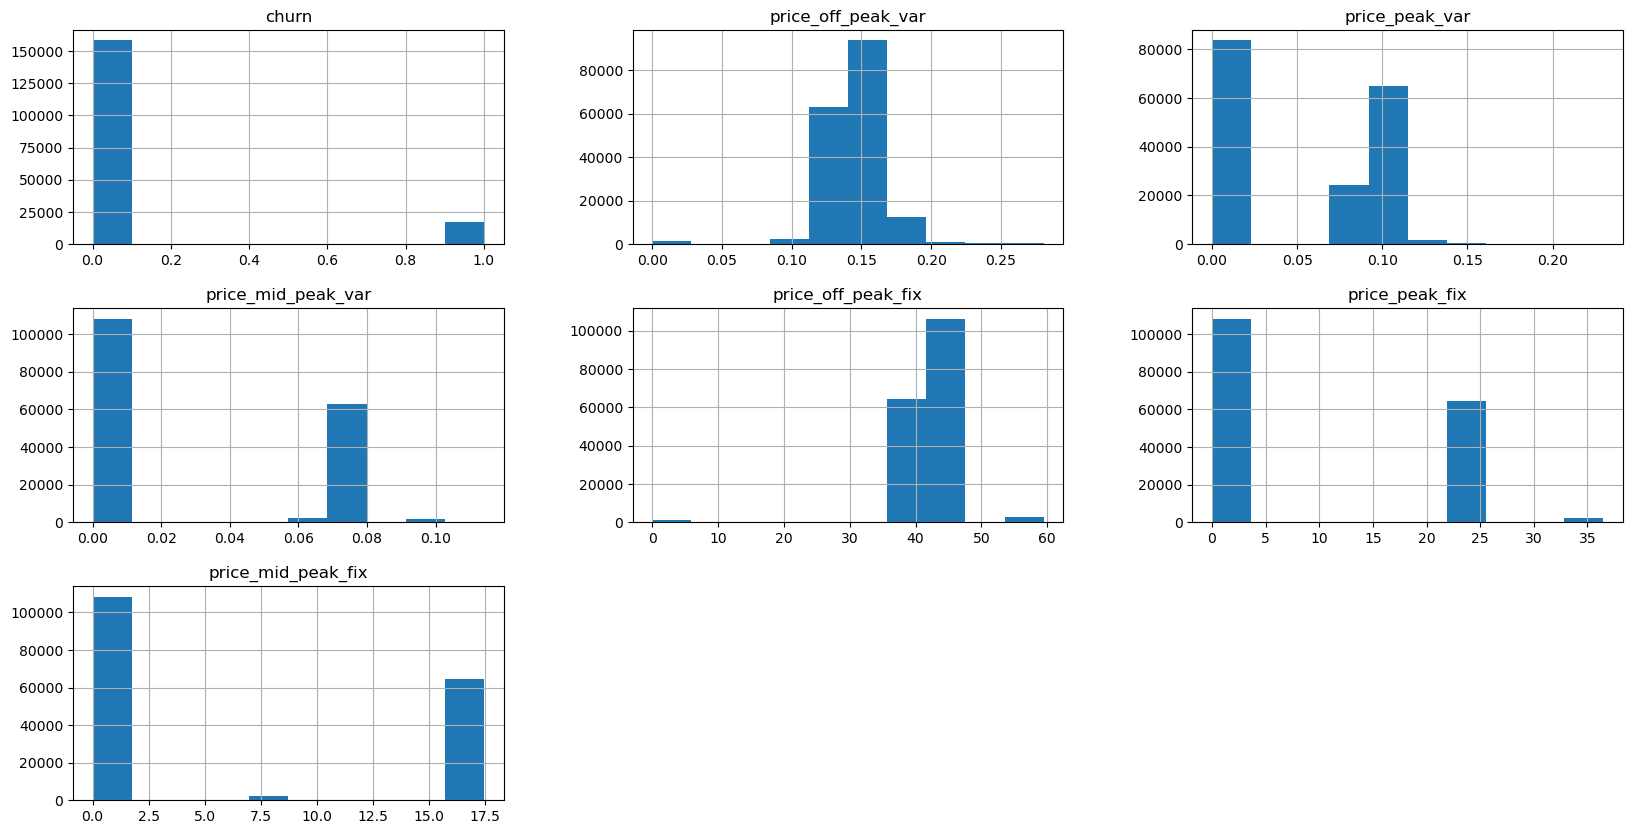

In [15]:
price_df.groupby(['id','price_date']).mean().hist(figsize=(20,10))
plt.show()

*The HistPlot shows that the data is skewed and show be treated before model creation*

## Plotting Energy and Power Prices

In [16]:
#Splitting the dataset into churn and non-churn price by price date

churn_grp_price = price_df[price_df['churn']==1].drop(columns=['id']).groupby(['price_date']).mean()
non_churn_grp_price = price_df[price_df['churn']==0].drop(columns=['id']).groupby(['price_date']).mean()

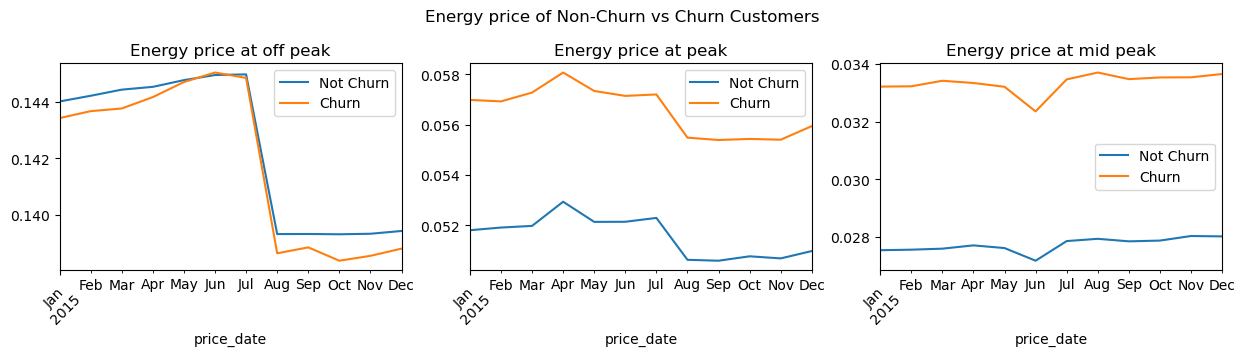

In [23]:
plt.figure(figsize=(15,3))
plt.axis('off')
plt.xticks(rotation=45)
plt.subplot(131)
non_churn_grp_price.price_off_peak_var.plot()
churn_grp_price.price_off_peak_var.plot()
plt.xticks(rotation=45)
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at off peak')
plt.subplot(132)
non_churn_grp_price.price_peak_var.plot()
churn_grp_price.price_peak_var.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at peak')
plt.xticks(rotation=45)
plt.subplot(133)
non_churn_grp_price.price_mid_peak_var.plot()
churn_grp_price.price_mid_peak_var.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Energy price at mid peak')
plt.xticks(rotation=45)
plt.suptitle('Energy price of Non-Churn vs Churn Customers')
plt.subplots_adjust(top=0.8)
plt.show()

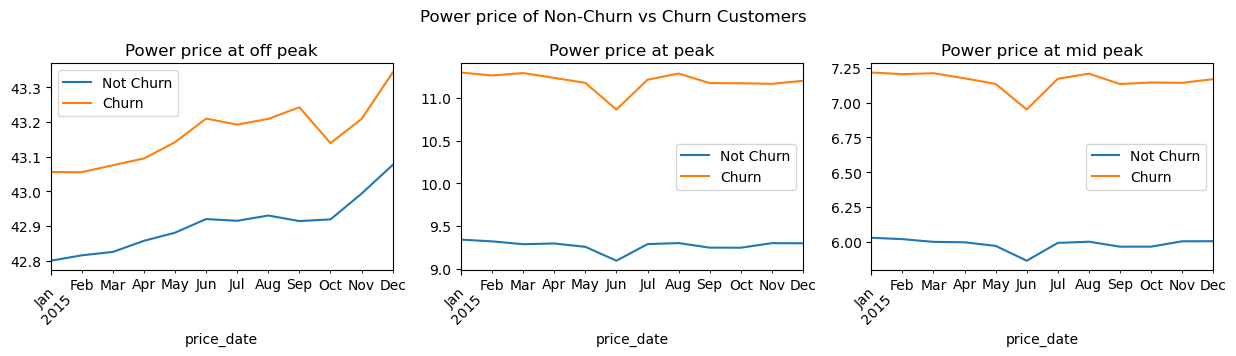

In [24]:
#Plotting average price of power by month
plt.figure(figsize=(15,3))
plt.axis('off')
plt.xticks(rotation=45)
plt.subplot(131)
non_churn_grp_price.price_off_peak_fix.plot()
churn_grp_price.price_off_peak_fix.plot()
plt.xticks(rotation=45)
plt.legend(['Not Churn','Churn'])
plt.title('Power price at off peak')
plt.subplot(132)
non_churn_grp_price.price_peak_fix.plot()
churn_grp_price.price_peak_fix.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Power price at peak')
plt.xticks(rotation=45)
plt.subplot(133)
non_churn_grp_price.price_mid_peak_fix.plot()
churn_grp_price.price_mid_peak_fix.plot()
plt.legend(['Not Churn','Churn'])
plt.title('Power price at mid peak')
plt.xticks(rotation=45)
plt.suptitle('Power price of Non-Churn vs Churn Customers')
plt.subplots_adjust(top=0.8)
plt.show()


There is some variation of price between churn and un-churn clients. Churned clients have slightly low off-peak energy prices and high off-peak power prices. But we can't confidently say this is the factor for churn. We need to analyze the data further to arrive at a concrete conclusion.

## Correlational Heatmap
Before merging the dataset with the client dataset, we should conduct a correlation analysis to identify the features replicating the same information.

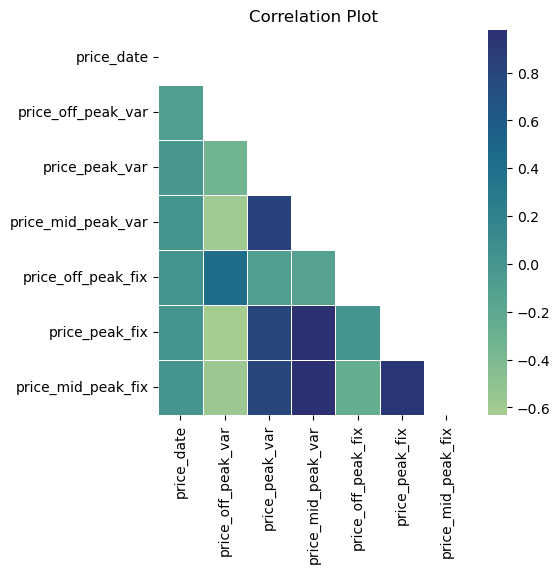

In [34]:
plt.figure(figsize=(5,5))
pd_corr = price_data.drop(columns=['id']).corr()
mask = np.triu(np.ones_like(pd_corr))
sns.heatmap(pd_corr,annot=True,cmap='crest',linewidths=.5,mask=mask)
plt.title('Correlation Plot')
plt.show()

'0.12.2'